# Facing the Music
## Binaural Sound Localisation with Machine Learning

In [22]:
import numpy as np
import sys
import IPython.display as ipd
import librosa
import matplotlib.pyplot as plt
from librosa import display

import data_generator_lib
import data_to_raw_numpy
import gccphat
import constants
import final_models
from custom_timer import Timer
from binaural import Binaural
from simulation import Simulation
from plotting import plotting

sys.path.append("../data/")
sys.path.append("../utils/")
sys.path.append("../models/")
sys.path.append("../simulation/")
sys.path.append("../visualization/")

# Download Data and Verify
* Download the Google Speech Commands dataset
* Plot and play and arbitrary sound
* This may take a while depending on your internet connection

/home/kevin/anaconda3/envs/facing-the-music/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


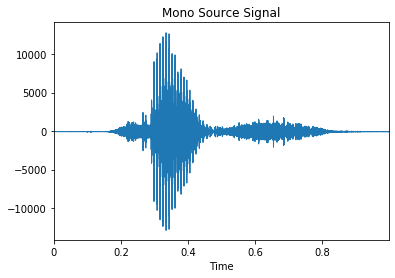

In [23]:
source = data_generator_lib.get_data(1)[5] 
display.waveplot(source.data.astype('float64'), source.fs)
plt.title('Mono Source Signal')
ipd.Audio(source.data, rate=source.fs)

# Full System Demo

* Choose a source distance and source azimuth

In [24]:
source_distance = 1
source_azimuth = 350

* Run the simulation

In [25]:
%%capture

sim = Simulation(directory="notebook_simulation",
                 source_azimuth=source_azimuth,
                 source_distance=source_distance,
                 model="gcc_cnn")

prediction = sim.simulate()

plot = plotting(room_dim=constants.room_dim,
                source_distance=source_distance,
                source_azimuth=source_azimuth,
                mic_centre=sim.mic_centre,
                rotation_list=sim.rotation_list,
                prediction_list=sim.predictions,
                prediction=sim.prediction)

demo = plot.plot_room(notebook=True)

* Display Results

In [26]:
demo

# What is going on inside?

## Set up an artificial room and "record" the audio
In this example we have: 
- 4x4x4 meter room
- Reflection order of 17
- Microphone height of 2m
- Inter microphone distance of 0.2m

In [27]:
room = Binaural(room_dim=np.r_[4., 4., 4.],
             max_order=17,
             speed_of_sound=343,
             inter_aural_distance=0.2,
             mic_height=2)

## "Record" the sound source. 

* This is the resulting audio of artificially placing the mono speech recording in our room
* The plot shows the room configuration
 - yellow dot is the sound source 
 - red dots are the microphones 


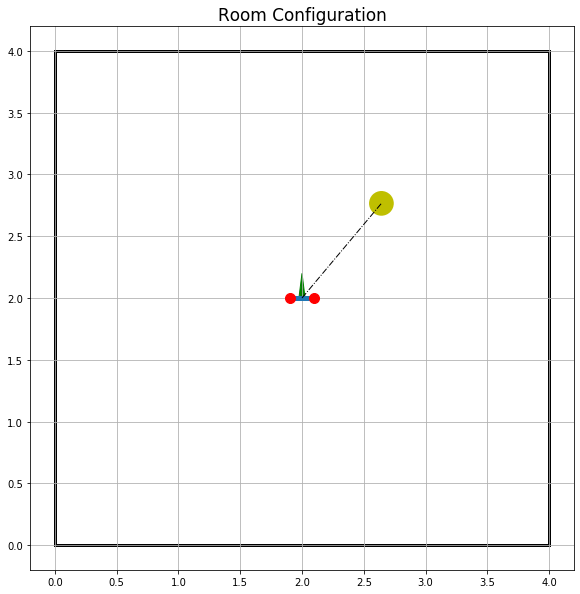

True Azimuth: 50.0


In [42]:
source_direction = 50

left, right, azimuth, file = room.generate_impulse_pair(source_azimuth_degrees=source_direction,
                               source_distance_from_room_centre=1,
                               SNR=0,
                               RT60=1,
                               mic_centre=np.array([2, 2]),
                               mic_rotation_degrees=0,
                               fs=source.fs,
                               source_signal=source.data,
                               plot_room=True,
                               plot_impulse=False,
                               write_wav=True,
                               wav_name="house_spatial_")

## Hear the speech signal now that it has been "placed" in the room

In [43]:
ipd.Audio("house_spatial_{doa}.wav".format(doa=float(source_direction)))

# How does the prediction work?
- Here we will explore how the direction of arrival prediction model works

## Generalised Cross-Correlation with Phase-Transfom
- A classic DSP method of performing sound source localisation is to compute the correlation between the two signals and then apply a weighting function called the "Phase-Transform"
- The time delay can then be computed by finding the sample delay at which the peak of the GCC-PHAT function occurs

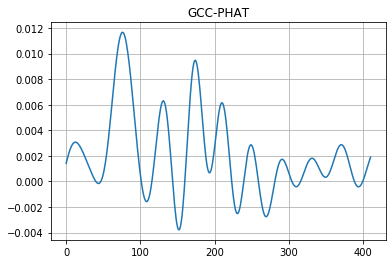

In [44]:
y, sr = librosa.load("house_spatial_{doa}.wav".format(doa=float(source_direction)), mono=False)
tau, gcc = gccphat.gcc_phat(y[1], y[0], fs=sr)
plt.plot(gcc)
plt.title("GCC-PHAT")
plt.grid()


## Compute Direction of Arrival using GCC-PHAT

In [46]:
theta = gccphat.tdoa(y[0], y[1], fs=sr)
print("Direction of Arrival: {doa} degrees".format(doa=np.round(theta,3)))

Direction of Arrival: 51.165 degrees


## The prediction was pretty good!
- What happens when we do the same computation on a direction of arrival greater than 180 degrees?

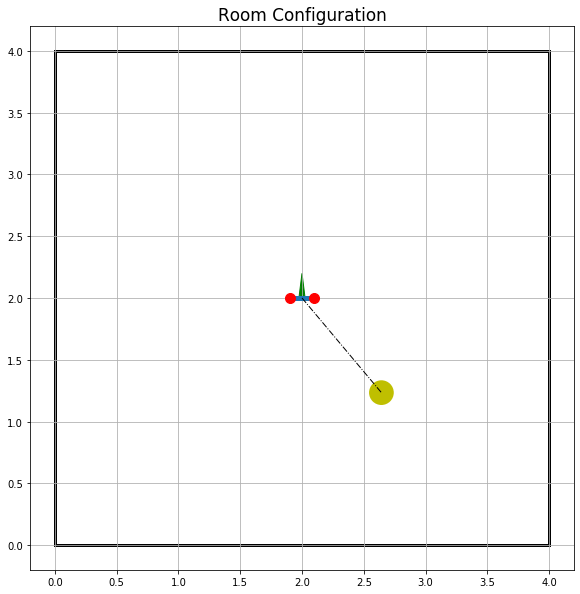

True Azimuth: 310.0
Direction of Arrival: 50.446 degrees


In [48]:
room.generate_impulse_pair(source_azimuth_degrees=310,
                           source_distance_from_room_centre=1,
                           SNR=0,
                           RT60=1,
                           mic_centre=np.array([2, 2]),
                           mic_rotation_degrees=0,
                           fs=source.fs,
                           source_signal=source.data,
                           plot_room=True,
                           plot_impulse=False,
                           write_wav=True,
                           wav_name="house_spatial_")

y_310, sr_310 = librosa.load("house_spatial_310.0.wav", mono=False)

theta_310 = gccphat.tdoa(y_310[0], y_310[1], fs=sr_310)
print("Direction of Arrival: {doa} degrees".format(doa=np.round(theta_310,3)))

## Something has gone wrong, the prediction is now very off!

- What is the problem? Using GCC-PHAT introduces an inherent ambiguity shown in the image below



## Front-Back Confusion


<img src="frontbackconfusion.png" width="512">

# How to fix this?

* We use a front-back labelling system.
* Each point is labelled with the two possible directions of arrival
* A CNN is then trained using this data and predicts a pair of possible direction of arrivals.
* This model is used in the code cell below

In [51]:
y_310 = librosa.resample(y_310, sr_310, 8000)
prediction = final_models.gcc_dsp().predict(y_310)
print("Possible Directions of Arrival: {doa} degrees".format(doa=prediction))

Model: gcc_dsp
Possible Directions of Arrival: [50.0, 310.0] degrees


##  How do we know which prediction is correct?
- A rotation algorithm was devised
- Successive predictions are made, and the probabilities of each DOA is then determined.
- The DOA with the greatest probability is chosen as the final prediction

<img src="rotationmodel_diagram.png" width="700">

# The full solution: GCC-PHAT + ConvNet + Rotations
- In this example, two direction of arrivals (70 degrees and 290 degrees) that would usually be confused when using GCC-PHAT are accurately predicted using our model

In [52]:
%%capture

source_distance = 1
source_azimuth = 70



sim = Simulation(directory="notebook_simulation",
                 source_azimuth=source_azimuth,
                 source_distance=source_distance,
                 model="gcc_cnn")

prediction = sim.simulate()

plot = plotting(room_dim=constants.room_dim,
                source_distance=source_distance,
                source_azimuth=source_azimuth,
                mic_centre=sim.mic_centre,
                rotation_list=sim.rotation_list,
                prediction_list=sim.predictions,
                prediction=sim.prediction)

demo = plot.plot_room(notebook=True)

print("Final Prediction: {prediction}".format(prediction=prediction))


In [53]:
demo

In [54]:
%%capture




sim_290 = Simulation(directory="notebook_simulation",
                 source_azimuth=290,
                 source_distance=1,
                 model="gcc_cnn")

prediction_290 = sim_290.simulate()

plot_290 = plotting(room_dim=constants.room_dim,
                source_distance=1,
                source_azimuth=290,
                mic_centre=sim_290.mic_centre,
                rotation_list=sim_290.rotation_list,
                prediction_list=sim_290.predictions,
                prediction=sim_290.prediction)

demo_290 = plot_290.plot_room(notebook=True)

print("Final Prediction: {prediction}".format(prediction=prediction_290))

In [55]:
demo_290